# `20180430a` - JSON Client - version p

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve
import json 
import re
import glob, os


## Creating the set of acquisitions

In [2]:
Serie = "wire"

wire/p_servo-23.json
second


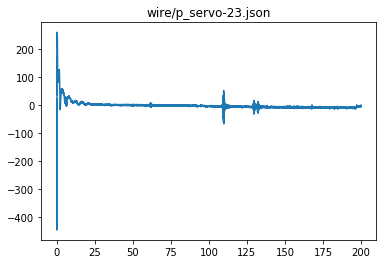

In [3]:
DataSet = {}


for data in glob.glob(Serie+"/p_ser*.json"):
    print data
    
    
    with open(data) as json_data:
        IDLine = []
        TT1 = []
        TT2 = []
        tmp = [] 
        DataSet[data] = {}
        d = json.load(json_data)
        json_data.close()
        
        A = d["data"][1:]
        
        if (A[0]) > 128:
            print "first"
            for i in range(len(A)/2-1):
                value = 128*(A[2*i+0]&0b0000111) + A[2*i+1] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16) # Identify the # of the line
                TT1.append( (A[2*i+0] & 0b00001000) / 0b1000)
                TT2.append( (A[2*i+0] & 0b00010000) / 0b10000)
                tmp.append( value ) 
        else:
            print "second"
            for i in range(len(A)/2-1):
                value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16)
                TT1.append( (A[2*i+1] & 0b00001000) / 0b1000)
                TT2.append( (A[2*i+1] & 0b00010000) / 0b10000)
                tmp.append( value )
        DataSet[data]["data"] = tmp
        DataSet[data]["IDLine"] = IDLine
        DataSet[data]["TT1"] = TT1
        DataSet[data]["TT2"] = TT2
        DataSet[data]["registers"] = d["registers"]
        DataSet[data]["position"] = d["position"]
        DataSet[data]["f"] = float(64/((1.0+int( d["registers"]["237"] ) )))
        t = [ 1.0*x/DataSet[data]["f"] for x in range(len(tmp))]
        DataSet[data]["t"] = t
        
        plt.plot(t,tmp)
        plt.title(data)
        plt.savefig(data+".jpg")
        plt.show() 

# Checking if arduino works to signal position

### Check if position is well marked

This should happen 3 times on the line

0b1010010


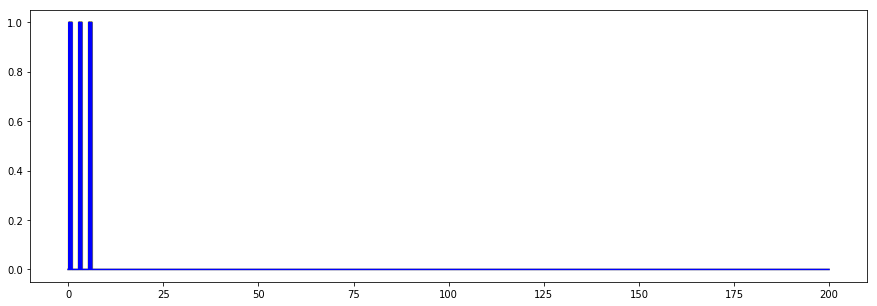

In [21]:
L1 = DataSet.keys()[0]
plt.figure(figsize=(15,5))
Position = 60 +  DataSet[L1]["position"]
print str(bin(Position))
plt.plot(DataSet[L1]["t"],DataSet[L1]["TT1"],"y")
plt.plot(DataSet[L1]["t"],DataSet[L1]["TT2"],"b")
plt.show()

0b1010010


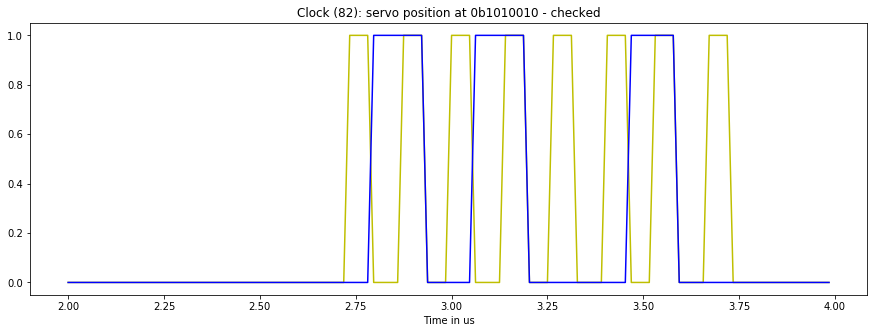

In [22]:
L1 = DataSet.keys()[0]
plt.figure(figsize=(15,5))
Position = 60 +  DataSet[L1]["position"]
print str(bin(Position))
plt.plot(DataSet[L1]["t"][2*64:4*64],DataSet[L1]["TT1"][2*64:4*64],"y")
plt.plot(DataSet[L1]["t"][2*64:4*64],DataSet[L1]["TT2"][2*64:4*64],"b")

plt.title("Clock ("+str(Position)+"): servo position at "+str(bin(Position)) + " - checked")
plt.savefig(Serie+"/clock_check_pos"+str(Position)+".jpg", bbox_inches='tight')
plt.xlabel("Time in us")
plt.show()

# Get back to the image

Using previously saved images sets.

In [28]:
Serie = "pu90"
filz = np.load(Serie+"/dataset.npz")

In [29]:
filz.files

['arr_1', 'arr_0']

In [30]:
image = filz["arr_1"]

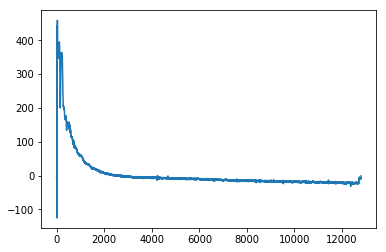

In [31]:
plt.plot(image[24])
plt.show()

## Let's check if a signal is well here

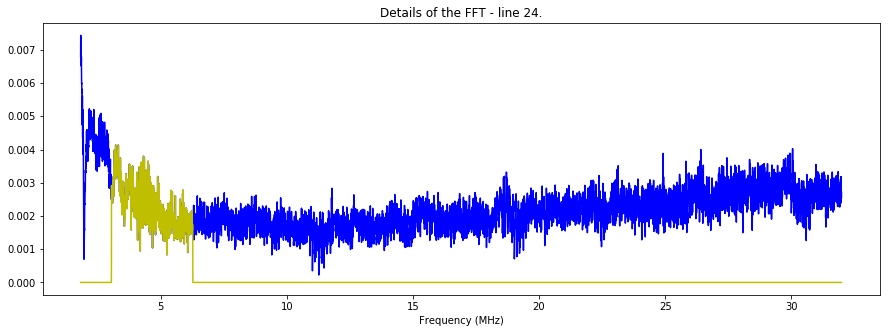

In [32]:
TestLine = 24

rawSig = image[TestLine]
FFT = np.fft.fft(rawSig)
FFTCleaned = np.fft.fft(rawSig)
FStart = 0.068*len(FFTCleaned)*0.7
FStop = 0.196*len(FFTCleaned)*0.5
for k in range(len(FFTCleaned)/2):
    if (k < FStart or k > FStop): # in (k < 550000 or k > 790000) # 0.068 0.196
        FFTCleaned[k] = 0
        FFTCleaned[-k] = 0

Scale = max(FFT)
ff = [ 64*2.0*x/(2*len(rawSig)) for x in range(len(rawSig)/2)]

plt.figure(figsize=(15,5))
plt.plot(ff[len(FFT)/35:len(FFT)/2],np.abs(FFT)[len(FFT)/35:len(FFT)/2]/Scale,"b")
plt.plot(ff[len(FFT)/35:len(FFT)/2],np.abs(FFTCleaned)[len(FFT)/35:len(FFT)/2]/Scale,"y")
plt.title("Details of the FFT - line "+str(TestLine)+".")  
plt.xlabel("Frequency (MHz)")
plt.savefig(Serie+"/fft.jpg", bbox_inches='tight')
plt.show()

Seems fine

In [33]:
F = np.real(np.fft.ifft(FFTCleaned))
FH = np.asarray(np.abs(signal.hilbert(F)))

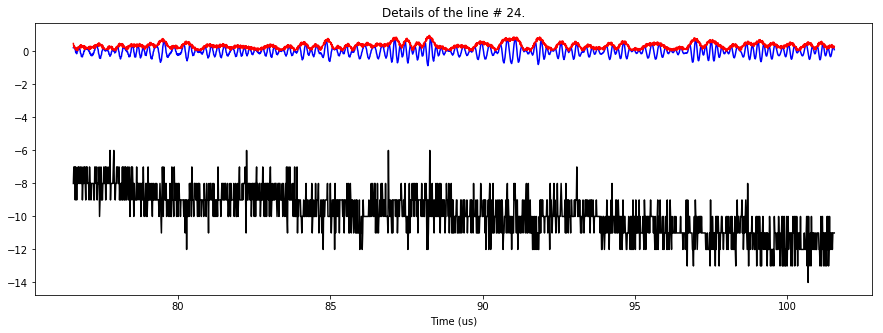

In [34]:
t = [ 1.0*x/64.0 for x in range(len(rawSig))]

plt.figure(figsize=(15,5))

plt.plot(t[4900:6500],F[4900:6500],"b")
plt.plot(t[4900:6500],rawSig[4900:6500],"k")
plt.plot(t[4900:6500],FH[4900:6500],"r")

plt.title("Details of the line # "+str(TestLine)+".")  
plt.xlabel("Time (us)")
plt.savefig(Serie+"/fft.jpg", bbox_inches='tight')

plt.show()

# Let's apply this to all cells

In [35]:
Hilberted = []

for j in range(len(image)):
    rawSig = image[j]
    FFT = np.fft.fft(rawSig)
    FFTCleaned = np.fft.fft(rawSig)
    FStart = 0.068*len(FFTCleaned)*0.7
    FStop = 0.196*len(FFTCleaned)*0.5
    for k in range(len(FFTCleaned)/2):
        if (k < FStart or k > FStop): # in (k < 550000 or k > 790000) # 0.068 0.196
            FFTCleaned[k] = 0
            FFTCleaned[-k] = 0

    Scale = max(FFT)
    ff = [ 64*2.0*x/(2*len(rawSig)) for x in range(len(rawSig)/2)]
    
    F = np.real(np.fft.ifft(FFTCleaned))
    FH = np.asarray(np.abs(signal.hilbert(F)))
    
    Hilberted.append(FH)

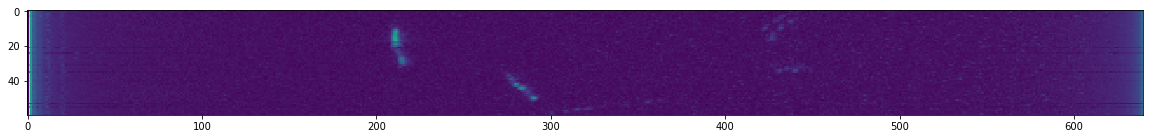

In [36]:
DH = []
for j in range(len(image)):
    DH.append( decimate(Hilberted[j], 20, ftype='fir') ) 
    
plt.figure(figsize=(20,10))
plt.imshow(np.sqrt(DH))
plt.show()

In [37]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    
    print LenLinesC,NbLinesC
    SC = np.zeros((LenLinesC,LenLinesC))+200
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.float)



    return SC,values,points,LenLinesC

In [38]:
SCH,valuesH,pointsH,LenLinesCH = CreateSC(np.sqrt(DH))
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')


640 60


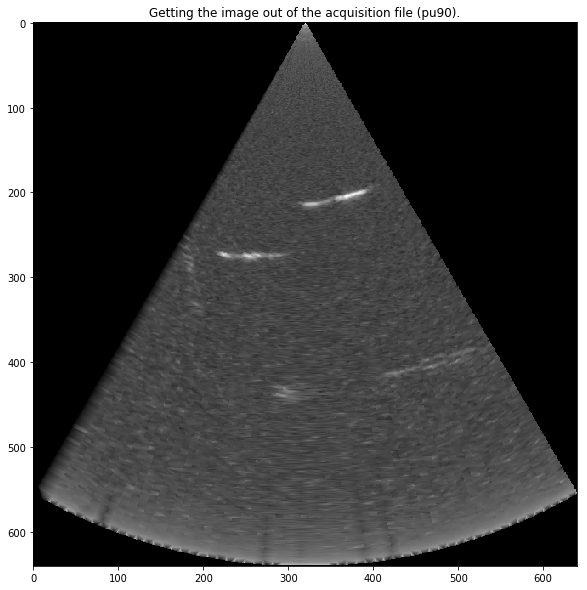

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(((grid_z1H+0.01)**0.5),cmap=plt.get_cmap('gray')) 
plt.title("Getting the image out of the acquisition file ("+Serie+").")  
plt.savefig(Serie+"/SCImage.jpg", bbox_inches='tight')
plt.show()